<a href="https://colab.research.google.com/github/Lehula1/divergGit/blob/main/scratchpad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install plotly
! pip install numpy
! pip install yfinance
! pip install pandas_ta
! pip install matplotlib
! pip install ta

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly
from pandas_datareader import data as pdr
import yfinance as yf
from scipy.signal import argrelextrema
import plotly.graph_objects as go
from collections import deque
from ta.momentum import StochasticOscillator
from plotly.subplots import make_subplots
import datetime as dt

ticker = 'AMD'
yfObj = yf.Ticker(ticker)
data = yfObj.history(period='3mo', interval='1d')

"""
data1 = yf.download(tickers='SPY', period='30d', interval='1d')

fig = go.Figure(data=[go.Candlestick(x=data1.index,
                                     open=data1['Open'],
                                     high=data1['High'],
                                     low=data1['Low'],
                                     close=data1['Close'])])


fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()
"""


"\ndata1 = yf.download(tickers='SPY', period='30d', interval='1d')\n\nfig = go.Figure(data=[go.Candlestick(x=data1.index,\n                                     open=data1['Open'],\n                                     high=data1['High'],\n                                     low=data1['Low'],\n                                     close=data1['Close'])])\n\n\nfig.update_layout(xaxis_rangeslider_visible=False)\nfig.show()\n"

In [ ]:
close = data['High'].values
dates = data.index
max_idx = argrelextrema(data['High'].values, np.greater, order=2)[0]
min_idx = argrelextrema(data['Low'].values, np.less, order=2)[0]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



# Get K consecutive higher peaks
K = 2
highs = data.iloc[max_idx]['High']

extrema = []
count = 0
ex_deque = deque(maxlen=K)
for i, idx in enumerate(max_idx):
  if i == 0:
    ex_deque.append(idx)
    continue
  if highs[i] < highs[i-1]:
    ex_deque.clear()
   
  ex_deque.append(idx)

  if len(ex_deque) == K:
    # K-consecutive higher highs found
    extrema.append(ex_deque.copy())
    #extrema count++++++++++++++++++++++++++++++++++++++++++++++++
    print(extrema[count][0])
    print(extrema[count][1])
    count += 1

test = data.iloc[extrema[0][0]]['High']

#print(highs)
print(data.iloc[max_idx])
print(ex_deque)
print(test)
print(extrema.index)
print(extrema[0][1])
print(extrema[1])
print(extrema[-1][1])
print(extrema)
print(max_idx)
print(data.index[max_idx])
print(data.iloc[max_idx,1])

In [7]:
# stochastic
stoch = StochasticOscillator(high=data['High'],
                             close=data['Close'],
                             low=data['Low'],
                             window=14, 
                             smooth_window=3)

fig=go.Figure()

fig = plotly.subplots.make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.01, 
                    row_heights=[0.5,0.2])

fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close']))

fig.add_trace(
    go.Scatter(
        mode='markers',
        x=data.index[max_idx],
        y=data.iloc[max_idx,1]+2,
        marker=dict(
            symbol='cross',
            color='green',
            size=10,
         
        )
    )
)

fig.add_trace(
    go.Scatter(
        mode='markers',
        x=data.index[min_idx],
        y=data.iloc[min_idx,2]-2,
        marker=dict(
            symbol='cross',
            color='red',
            size=10)))

fig.add_trace(
    go.Scatter(
        x=[data.index[extrema[-1][0]], data.index[extrema[-1][1]]],
        y=[data.iloc[extrema[-1][0],1], data.iloc[extrema[-1][1],1]],
        mode='lines',
        name='trend line',
        line=dict(color='blue')))

fig.add_trace(go.Scatter(x=data.index,
                         y=stoch.stoch(),
                         line=dict(color='black', width=2)
                        ), row=2, col=1)


fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"])] #hide weekends  
)

fig.update_layout(xaxis_rangeslider_visible=False)



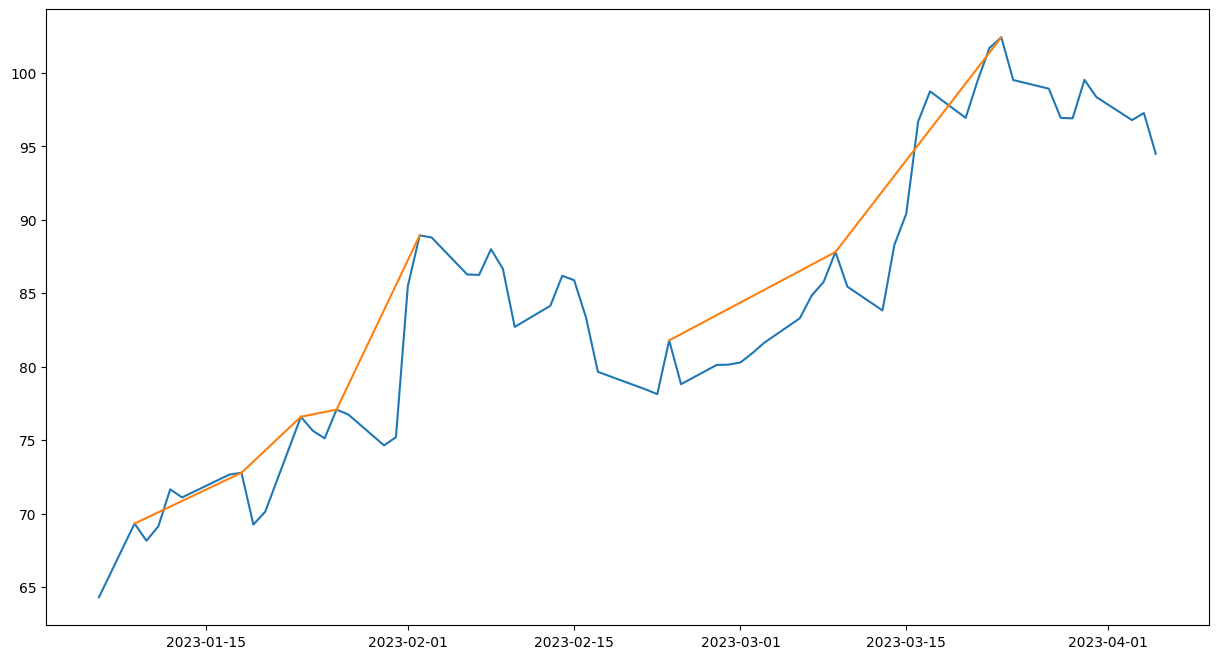

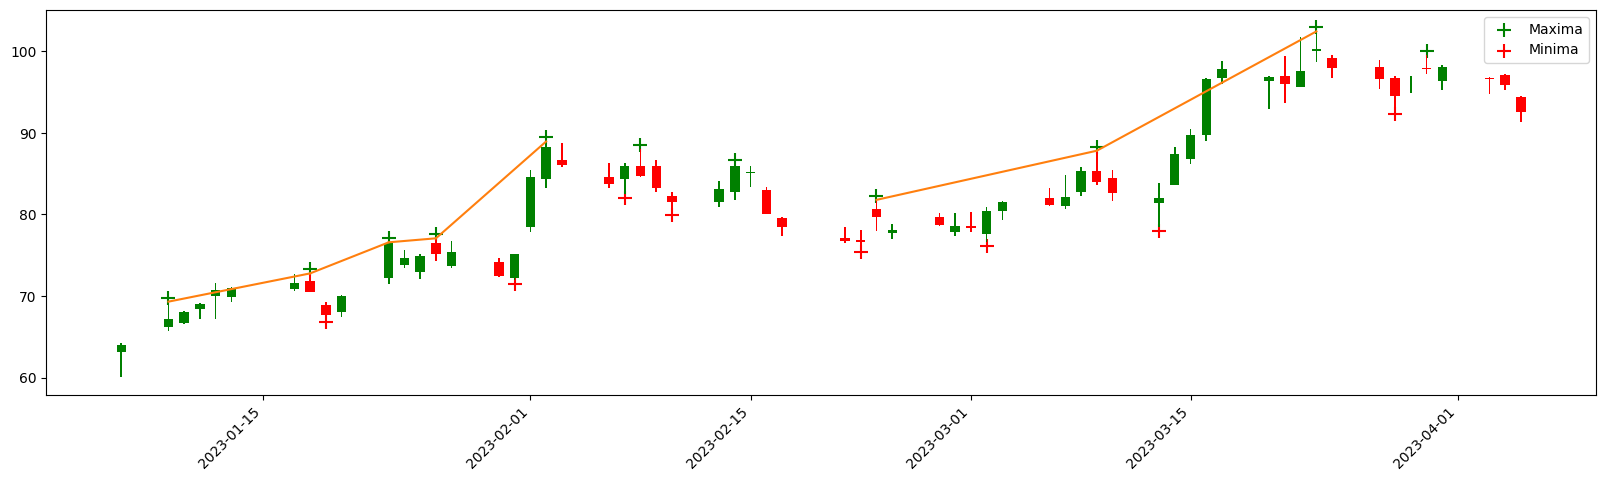

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(data['High'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]


#create figure
plt.figure(figsize=(20,5))

plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['High']+.5,
  label='Maxima', s=100, color='green', marker='+')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['Low']-.5,
  label='Minima', s=100, color='red', marker='+')

#define width of candlestick elements
width = .6
width2 = .1

#define up and down prices
up = data[data['Close']>=data['Open']]
down = data[data['Close']<data['Open']]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
plt.bar(up.index,up['Close']-up['Open'],width,bottom=up['Open'],color=col1)
plt.bar(up.index,up['High']-up['Close'],width2,bottom=up['Close'],color=col1)
plt.bar(up.index,up['Low']-up['Open'],width2,bottom=up['Open'],color=col1)

#plot down prices
plt.bar(down.index,down['Close']-down['Open'],width,bottom=down['Open'],color=col2)
plt.bar(down.index,down['High']-down['Open'],width2,bottom=down['Open'],color=col2)
plt.bar(down.index,down['Low']-down['Close'],width2,bottom=down['Close'],color=col2)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#lines
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]

plt.legend()
#display candlestick chart
plt.show()